#Importing Libraries

In [1]:
import os
import shutil


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Making the Resnet Model Archithecture

In [3]:
class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self,in_channels,out_channels,indentity_downsample = None, stride=1):
    super().__init__()

    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,stride =stride,padding =1 , bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,stride = 1,padding =1 , bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    self.in_channels = in_channels
    self.out_channels = out_channels

    self.indentity_downsample = indentity_downsample
    self.stride =  stride
    self.relu = nn.ReLU()


  def forward(self,x):
    identity = x.clone()

    x = self.conv1(x)
    x =  self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x =  self.bn2(x)

    if self.indentity_downsample is not None:
      identity = self.indentity_downsample(identity)
    # Handle dimension matching with LambdaLayer (as in option A of the first code)
    if self.stride != 1:
      padding = self.out_channels-x.shape[1]
      identity = F.pad(identity, (0, 0, 0, 0, 0, padding, 0, 0))


    x +=identity
    x = self.relu(x)
    return x






In [4]:
class ResNet(nn.Module):

  def __init__(self,BasicBlock,num_blocks,no_classes = 10):
    super(ResNet, self).__init__()
    self.in_channels = 16

    self.conv1 = nn.Conv2d(
        3, 16 , kernel_size = 3 , stride=1, padding=1 , bias = False
    )
    self.bn1 = nn.BatchNorm2d(16)
    self.relu = nn.ReLU()

    self.layer1 = self.make_layer(BasicBlock, 16, num_blocks[0], stride=1)
    self.layer2 = self.make_layer(BasicBlock, 32, num_blocks[1], stride=2)
    self.layer3 = self.make_layer(BasicBlock, 64, num_blocks[2], stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(64,no_classes)


  def forward(self,x):
    x = self.conv1(x)
    x= self.bn1(x)
    x = self.relu(x)


    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)


    x = self.avgpool(x)
    x = x.reshape(x.shape[0],-1)
    x = self.fc(x)

    return x


  def make_layer(self, BasicBlock, out_channels, num_residual_blocks, stride):
      layers = []

      if stride != 1 or self.in_channels != out_channels * BasicBlock.expansion:
          identity_downsample = nn.Sequential(
              nn.Conv2d(self.in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
              nn.BatchNorm2d(out_channels * BasicBlock.expansion)
          )

      else:
          identity_downsample = None

      layers.append(BasicBlock(self.in_channels, out_channels, identity_downsample, stride))
      self.in_channels = out_channels * BasicBlock.expansion

      for i in range(num_residual_blocks - 1):
          layers.append(BasicBlock(self.in_channels, out_channels))

      return nn.Sequential(*layers)







In [5]:
def ResNet20(num_classes):
    return ResNet(BasicBlock, [3,3,3], num_classes)


In [6]:
def ResNet44(num_classes):
    return ResNet(BasicBlock, [7,7,7], num_classes)


In [7]:
def ResNet56(num_classes):
    return ResNet(BasicBlock, [9,9,9], num_classes)

In [8]:
resnet20_model = ResNet20(10)
resnet44_model = ResNet44(num_classes=10)
resnet56_model = ResNet56(num_classes=10)

In [9]:
resnet56_model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

resnet56_model.to(device)
summary(resnet56_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

# on CIFAR10 Dataset

In [10]:
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim


In [11]:
# image transforms as per the paper + Normalization
image_transforms = {
    'train': transforms.Compose([
          transforms.RandomCrop(32, padding=4),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
}

## Loading the Data

In [12]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=image_transforms['train'])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=image_transforms['test'])



100%|██████████| 170498071/170498071 [00:01<00:00, 86975098.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
print(f"Length of train_dataset {len(train_dataset)}")
print(f"Length of train_dataset {len(test_dataset)}")


Length of train_dataset 50000
Length of train_dataset 10000


In [14]:

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [15]:
train_dataset, val_dataset = random_split(train_dataset, (45000, 5000))


In [16]:
train_samples= len(train_dataset)
val_samples= len(val_dataset)
test_samples = len(test_dataset)

In [17]:
batch_size = 32

# Generate dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

## Loss function , Optimizer and scheduler

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet56_model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor =0.1 , patience=5)

## Just cheching my codes works or not

In [20]:
X, y = next(iter(train_loader))
print(X)
X = X.to(device,dtype = torch.float32)
y = y.to(device)

predictions = resnet56_model(X)
print(f"This is the actual prediction my model makes{predictions.shape}")
softmax_predictions = F.softmax(predictions, dim=1)
prediction_classes = torch.argmax(softmax_predictions, dim=1)
print(f"This is predictions after argmax:\n{prediction_classes}")
print(f"This is y = {y} \\ and length of y is {len(y)} ")

criterion(predictions,y)

tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -0.8353, -0.8667, -0.8902],
          [-1.0000, -1.0000, -1.0000,  ..., -0.8745, -0.8980, -0.9294],
          [-1.0000, -1.0000, -1.0000,  ..., -0.8745, -0.9059, -0.9373]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -0.8824, -0.9059, -0.9216],
          [-1.0000, -1.0000, -1.0000,  ..., -0.8902, -0.9137, -0.9451],
          [-1.0000, -1.0000, -1.0000,  ..., -0.8980, -0.9059, -0.9373]],

         [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -

tensor(2.5392, device='cuda:0', grad_fn=<NllLossBackward0>)

## Training Function

In [21]:
import time
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    train_costs, val_costs = [], []
    train_accuracies ,val_accuracies = [] ,[]
    min_loss = float('inf')



    for epoch in range(num_epochs):
        train_running_loss = 0
        correct_train = 0
        model.train().cuda()
        train_loader = tqdm(train_loader, desc="Training")
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            prediction = model(inputs)
            loss = criterion(prediction, labels)
            loss.backward()
            optimizer.step()
            _, predicted_outputs = torch.max(prediction.data, 1)
            correct_train += (predicted_outputs == labels).float().sum().item()
            train_running_loss += (loss.data.item() * inputs.shape[0])



        train_epoch_loss = train_running_loss / train_samples
        train_costs.append(train_epoch_loss)
        train_acc = correct_train / train_samples
        train_accuracies.append(train_acc)

        val_running_loss = 0
        correct_val = 0
        model.eval().cuda()

        val_loader = tqdm(val_loader, desc="Validation")
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                prediction = model(inputs)
                loss = criterion(prediction, labels)
                _, predicted_outputs = torch.max(prediction.data, 1)
                correct_val += (predicted_outputs == labels).float().sum().item()
                val_running_loss += (loss.data.item() * inputs.shape[0])


            val_running_loss += (loss.data.item() * inputs.shape[0])
            val_epoch_loss = val_running_loss / val_samples
            val_costs.append(val_epoch_loss)
            val_acc = correct_val / val_samples
            val_accuracies.append(val_acc)

        info = "[Epoch {}/{}]: train-loss = {:0.6f} | train-acc = {:0.3f} | val-loss = {:0.6f} | val-acc = {:0.3f}"

        print(info.format(epoch + 1, num_epochs, train_epoch_loss, train_acc, val_epoch_loss, val_acc))

        # Update the learning rate based on validation loss
        scheduler.step(val_epoch_loss)

        if val_epoch_loss < min_loss:
            min_loss = val_epoch_loss
            best_model_state = model.state_dict()

    return train_costs, val_costs,train_accuracies,val_accuracies, best_model_state


# Resnet56 Model

In [30]:
train_costs, val_costs,train_accuracies,val_accuracies, best_model_state = train_model(resnet56_model, train_loader, val_loader, criterion, optimizer, num_epochs=30)


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.61it/s]


[Epoch 1/30]: train-loss = 0.906943 | train-acc = 0.683 | val-loss = 0.939239 | val-acc = 0.679


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.72it/s]


[Epoch 2/30]: train-loss = 0.785576 | train-acc = 0.728 | val-loss = 0.793592 | val-acc = 0.726


Validation: 100%|██████████| 157/157 [00:05<00:00, 28.26it/s]


[Epoch 3/30]: train-loss = 0.712580 | train-acc = 0.753 | val-loss = 0.734767 | val-acc = 0.751


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.79it/s]


[Epoch 4/30]: train-loss = 0.660159 | train-acc = 0.773 | val-loss = 0.787473 | val-acc = 0.737


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.09it/s]


[Epoch 5/30]: train-loss = 0.627635 | train-acc = 0.783 | val-loss = 0.816933 | val-acc = 0.732


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.62it/s]


[Epoch 6/30]: train-loss = 0.596017 | train-acc = 0.795 | val-loss = 0.677283 | val-acc = 0.770


Validation: 100%|██████████| 157/157 [00:04<00:00, 37.61it/s]


[Epoch 7/30]: train-loss = 0.571537 | train-acc = 0.804 | val-loss = 0.636148 | val-acc = 0.786


Validation: 100%|██████████| 157/157 [00:03<00:00, 39.79it/s]


[Epoch 8/30]: train-loss = 0.554816 | train-acc = 0.810 | val-loss = 0.547753 | val-acc = 0.808


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.52it/s]


[Epoch 9/30]: train-loss = 0.530592 | train-acc = 0.817 | val-loss = 0.618189 | val-acc = 0.791


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.72it/s]


[Epoch 10/30]: train-loss = 0.523941 | train-acc = 0.821 | val-loss = 0.673958 | val-acc = 0.772


Validation: 100%|██████████| 157/157 [00:03<00:00, 47.39it/s]


[Epoch 11/30]: train-loss = 0.506142 | train-acc = 0.825 | val-loss = 0.623784 | val-acc = 0.785


Validation: 100%|██████████| 157/157 [00:04<00:00, 37.06it/s]


[Epoch 12/30]: train-loss = 0.491220 | train-acc = 0.831 | val-loss = 0.552057 | val-acc = 0.810


Validation: 100%|██████████| 157/157 [00:03<00:00, 39.68it/s]


[Epoch 13/30]: train-loss = 0.483839 | train-acc = 0.835 | val-loss = 0.562681 | val-acc = 0.812


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.49it/s]


[Epoch 14/30]: train-loss = 0.470982 | train-acc = 0.838 | val-loss = 0.520619 | val-acc = 0.819


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.66it/s]


[Epoch 15/30]: train-loss = 0.465247 | train-acc = 0.840 | val-loss = 0.631182 | val-acc = 0.788


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.30it/s]


[Epoch 16/30]: train-loss = 0.461266 | train-acc = 0.841 | val-loss = 0.730949 | val-acc = 0.772


Validation: 100%|██████████| 157/157 [00:04<00:00, 37.40it/s]


[Epoch 17/30]: train-loss = 0.459482 | train-acc = 0.842 | val-loss = 0.576393 | val-acc = 0.809


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.91it/s]


[Epoch 18/30]: train-loss = 0.445926 | train-acc = 0.847 | val-loss = 0.580202 | val-acc = 0.799


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.66it/s]


[Epoch 19/30]: train-loss = 0.443664 | train-acc = 0.847 | val-loss = 0.464247 | val-acc = 0.848


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.48it/s]


[Epoch 20/30]: train-loss = 0.434540 | train-acc = 0.849 | val-loss = 0.542566 | val-acc = 0.818


Validation: 100%|██████████| 157/157 [00:04<00:00, 38.60it/s]


[Epoch 21/30]: train-loss = 0.430723 | train-acc = 0.852 | val-loss = 0.496269 | val-acc = 0.838


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.38it/s]


[Epoch 22/30]: train-loss = 0.430234 | train-acc = 0.853 | val-loss = 0.503644 | val-acc = 0.831


Validation: 100%|██████████| 157/157 [00:03<00:00, 47.58it/s]


[Epoch 23/30]: train-loss = 0.425180 | train-acc = 0.854 | val-loss = 0.460313 | val-acc = 0.837


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.11it/s]


[Epoch 24/30]: train-loss = 0.420446 | train-acc = 0.857 | val-loss = 0.556377 | val-acc = 0.815


Validation: 100%|██████████| 157/157 [00:03<00:00, 43.93it/s]


[Epoch 25/30]: train-loss = 0.411229 | train-acc = 0.859 | val-loss = 0.492459 | val-acc = 0.837


Validation: 100%|██████████| 157/157 [00:05<00:00, 31.12it/s]


[Epoch 26/30]: train-loss = 0.417494 | train-acc = 0.857 | val-loss = 0.514739 | val-acc = 0.824


Validation: 100%|██████████| 157/157 [00:03<00:00, 48.68it/s]


[Epoch 27/30]: train-loss = 0.417889 | train-acc = 0.856 | val-loss = 0.507874 | val-acc = 0.825


Validation: 100%|██████████| 157/157 [00:03<00:00, 48.26it/s]


[Epoch 28/30]: train-loss = 0.409194 | train-acc = 0.859 | val-loss = 0.492030 | val-acc = 0.832


Validation: 100%|██████████| 157/157 [00:04<00:00, 37.53it/s]


[Epoch 29/30]: train-loss = 0.409586 | train-acc = 0.859 | val-loss = 0.502418 | val-acc = 0.840


Validation: 100%|██████████| 157/157 [00:03<00:00, 41.36it/s]

[Epoch 30/30]: train-loss = 0.249816 | train-acc = 0.915 | val-loss = 0.280824 | val-acc = 0.908


In [31]:
# Save the trained model
model_save_path = "/content/drive/MyDrive/SEM3/Interview_Asignment/resnet_56.pth"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

torch.save(best_model_state, model_save_path)


In [32]:
model= ResNet56(10)
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [33]:

correct = 0

model.eval().cuda()

with  torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Make predictions.
        prediction = model(inputs)

        # Retrieve predictions indexes.
        _, predicted_class = torch.max(prediction.data, 1)

        # Compute number of correct predictions.
        correct += (predicted_class == labels).float().sum().item()

test_accuracy = correct / test_samples
print('Test accuracy: {}'.format(test_accuracy))

Test accuracy: 0.8984


In [34]:
import matplotlib.pyplot as plt

def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    num_epochs = len(train_losses)
    epochs = list(range(1, num_epochs + 1))  # Generate a list of epochs [1, 2, 3, ...]


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training and validation loss
    ax1.plot(epochs,train_losses, label='Training Loss')
    ax1.plot(epochs,val_losses, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()

    # Plot training and validation accuracy
    ax2.plot(epochs,train_accuracies, label='Training Accuracy')
    ax2.plot(epochs,val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()


    plt.show()



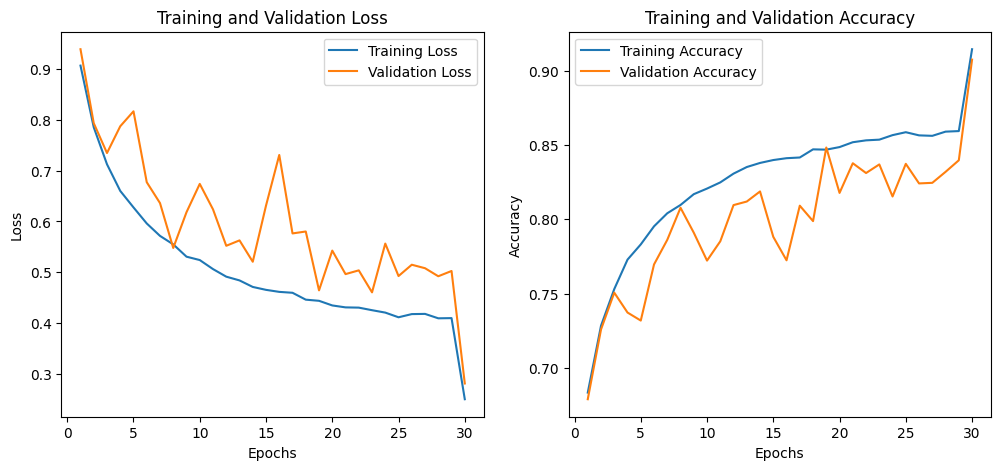

In [35]:
plot_training_results(train_costs, val_costs, train_accuracies, val_accuracies)


# Resnet20 model

In [36]:
optimizer_20 = optim.SGD(resnet20_model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)


In [37]:
train_costs, val_costs,train_accuracies,val_accuracies,  best_model_state = train_model(resnet20_model, train_loader, val_loader, criterion, optimizer_20, num_epochs=40)


Validation: 100%|██████████| 157/157 [00:02<00:00, 62.53it/s]


[Epoch 1/40]: train-loss = 1.824768 | train-acc = 0.302 | val-loss = 1.575983 | val-acc = 0.428


Validation: 100%|██████████| 157/157 [00:02<00:00, 61.73it/s]


[Epoch 2/40]: train-loss = 1.345760 | train-acc = 0.511 | val-loss = 1.151556 | val-acc = 0.583


Validation: 100%|██████████| 157/157 [00:02<00:00, 61.96it/s]


[Epoch 3/40]: train-loss = 1.053603 | train-acc = 0.627 | val-loss = 0.951971 | val-acc = 0.674


Validation: 100%|██████████| 157/157 [00:02<00:00, 63.05it/s]


[Epoch 4/40]: train-loss = 0.900722 | train-acc = 0.683 | val-loss = 0.808361 | val-acc = 0.716


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.86it/s]


[Epoch 5/40]: train-loss = 0.782230 | train-acc = 0.727 | val-loss = 0.688290 | val-acc = 0.772


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.88it/s]


[Epoch 6/40]: train-loss = 0.712989 | train-acc = 0.752 | val-loss = 0.686575 | val-acc = 0.767


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.88it/s]


[Epoch 7/40]: train-loss = 0.663556 | train-acc = 0.772 | val-loss = 0.658520 | val-acc = 0.778


Validation: 100%|██████████| 157/157 [00:02<00:00, 53.16it/s]


[Epoch 8/40]: train-loss = 0.627308 | train-acc = 0.782 | val-loss = 0.677539 | val-acc = 0.762


Validation: 100%|██████████| 157/157 [00:02<00:00, 62.04it/s]


[Epoch 9/40]: train-loss = 0.601317 | train-acc = 0.794 | val-loss = 0.762668 | val-acc = 0.743


Validation: 100%|██████████| 157/157 [00:02<00:00, 60.78it/s]


[Epoch 10/40]: train-loss = 0.581060 | train-acc = 0.801 | val-loss = 0.619996 | val-acc = 0.789


Validation: 100%|██████████| 157/157 [00:02<00:00, 62.52it/s]


[Epoch 11/40]: train-loss = 0.560011 | train-acc = 0.807 | val-loss = 0.556223 | val-acc = 0.808


Validation: 100%|██████████| 157/157 [00:02<00:00, 63.51it/s]


[Epoch 12/40]: train-loss = 0.547524 | train-acc = 0.812 | val-loss = 0.621227 | val-acc = 0.789


Validation: 100%|██████████| 157/157 [00:02<00:00, 62.13it/s]


[Epoch 13/40]: train-loss = 0.538075 | train-acc = 0.817 | val-loss = 0.651720 | val-acc = 0.780


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.39it/s]


[Epoch 14/40]: train-loss = 0.524236 | train-acc = 0.820 | val-loss = 0.607656 | val-acc = 0.796


Validation: 100%|██████████| 157/157 [00:02<00:00, 59.00it/s]


[Epoch 15/40]: train-loss = 0.516357 | train-acc = 0.822 | val-loss = 0.620734 | val-acc = 0.782


Validation: 100%|██████████| 157/157 [00:02<00:00, 56.33it/s]


[Epoch 16/40]: train-loss = 0.506105 | train-acc = 0.826 | val-loss = 0.561451 | val-acc = 0.805


Validation: 100%|██████████| 157/157 [00:02<00:00, 60.36it/s]


[Epoch 17/40]: train-loss = 0.496862 | train-acc = 0.830 | val-loss = 0.562232 | val-acc = 0.810


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.73it/s]


[Epoch 18/40]: train-loss = 0.488142 | train-acc = 0.833 | val-loss = 0.534001 | val-acc = 0.819


Validation: 100%|██████████| 157/157 [00:03<00:00, 50.52it/s]


[Epoch 19/40]: train-loss = 0.487894 | train-acc = 0.832 | val-loss = 0.473551 | val-acc = 0.834


Validation: 100%|██████████| 157/157 [00:02<00:00, 62.20it/s]


[Epoch 20/40]: train-loss = 0.480020 | train-acc = 0.836 | val-loss = 0.503519 | val-acc = 0.827


Validation: 100%|██████████| 157/157 [00:02<00:00, 62.75it/s]


[Epoch 21/40]: train-loss = 0.471386 | train-acc = 0.837 | val-loss = 0.540125 | val-acc = 0.813


Validation: 100%|██████████| 157/157 [00:02<00:00, 59.29it/s]


[Epoch 22/40]: train-loss = 0.478230 | train-acc = 0.835 | val-loss = 0.543148 | val-acc = 0.818


Validation: 100%|██████████| 157/157 [00:02<00:00, 60.69it/s]


[Epoch 23/40]: train-loss = 0.469205 | train-acc = 0.838 | val-loss = 0.485126 | val-acc = 0.832


Validation: 100%|██████████| 157/157 [00:02<00:00, 62.22it/s]


[Epoch 24/40]: train-loss = 0.463444 | train-acc = 0.839 | val-loss = 0.512140 | val-acc = 0.829


Validation: 100%|██████████| 157/157 [00:03<00:00, 48.06it/s]


[Epoch 25/40]: train-loss = 0.459723 | train-acc = 0.841 | val-loss = 0.541230 | val-acc = 0.819


Validation: 100%|██████████| 157/157 [00:03<00:00, 48.04it/s]


[Epoch 26/40]: train-loss = 0.456977 | train-acc = 0.842 | val-loss = 0.535404 | val-acc = 0.815


Validation: 100%|██████████| 157/157 [00:02<00:00, 62.21it/s]


[Epoch 27/40]: train-loss = 0.457061 | train-acc = 0.844 | val-loss = 0.488160 | val-acc = 0.831


Validation: 100%|██████████| 157/157 [00:02<00:00, 62.80it/s]


[Epoch 28/40]: train-loss = 0.446143 | train-acc = 0.847 | val-loss = 0.488399 | val-acc = 0.832


Validation: 100%|██████████| 157/157 [00:02<00:00, 62.10it/s]


[Epoch 29/40]: train-loss = 0.447373 | train-acc = 0.844 | val-loss = 0.593662 | val-acc = 0.794


Validation: 100%|██████████| 157/157 [00:02<00:00, 60.60it/s]


[Epoch 30/40]: train-loss = 0.452755 | train-acc = 0.844 | val-loss = 0.571179 | val-acc = 0.814


Validation: 100%|██████████| 157/157 [00:02<00:00, 59.63it/s]


[Epoch 31/40]: train-loss = 0.445454 | train-acc = 0.847 | val-loss = 0.551594 | val-acc = 0.818


Validation: 100%|██████████| 157/157 [00:03<00:00, 44.33it/s]


[Epoch 32/40]: train-loss = 0.442512 | train-acc = 0.849 | val-loss = 0.474573 | val-acc = 0.839


Validation: 100%|██████████| 157/157 [00:03<00:00, 50.90it/s]


[Epoch 33/40]: train-loss = 0.440834 | train-acc = 0.847 | val-loss = 0.549584 | val-acc = 0.819


Validation: 100%|██████████| 157/157 [00:02<00:00, 61.72it/s]


[Epoch 34/40]: train-loss = 0.438246 | train-acc = 0.849 | val-loss = 0.499145 | val-acc = 0.830


Validation: 100%|██████████| 157/157 [00:02<00:00, 62.71it/s]


[Epoch 35/40]: train-loss = 0.433966 | train-acc = 0.850 | val-loss = 0.503604 | val-acc = 0.824


Validation: 100%|██████████| 157/157 [00:02<00:00, 61.92it/s]


[Epoch 36/40]: train-loss = 0.435259 | train-acc = 0.853 | val-loss = 0.559255 | val-acc = 0.811


Validation: 100%|██████████| 157/157 [00:02<00:00, 63.17it/s]


[Epoch 37/40]: train-loss = 0.434958 | train-acc = 0.851 | val-loss = 0.484468 | val-acc = 0.839


Validation: 100%|██████████| 157/157 [00:02<00:00, 54.52it/s]


[Epoch 38/40]: train-loss = 0.430641 | train-acc = 0.851 | val-loss = 0.590674 | val-acc = 0.799


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.88it/s]


[Epoch 39/40]: train-loss = 0.429004 | train-acc = 0.852 | val-loss = 0.484402 | val-acc = 0.838


Validation: 100%|██████████| 157/157 [00:03<00:00, 47.92it/s]

[Epoch 40/40]: train-loss = 0.427403 | train-acc = 0.852 | val-loss = 0.523240 | val-acc = 0.820


In [38]:
# Save the trained model
model_save_path = "/content/drive/MyDrive/SEM3/Interview_Asignment/resnet_20.pth"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

torch.save(best_model_state, model_save_path)

In [39]:
model= ResNet20(10)
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [40]:

correct = 0

model.eval().cuda()

with  torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Make predictions.
        prediction = model(inputs)

        # Retrieve predictions indexes.
        _, predicted_class = torch.max(prediction.data, 1)

        # Compute number of correct predictions.
        correct += (predicted_class == labels).float().sum().item()

test_accuracy = correct / test_samples
print('Test accuracy: {}'.format(test_accuracy))

Test accuracy: 0.8129


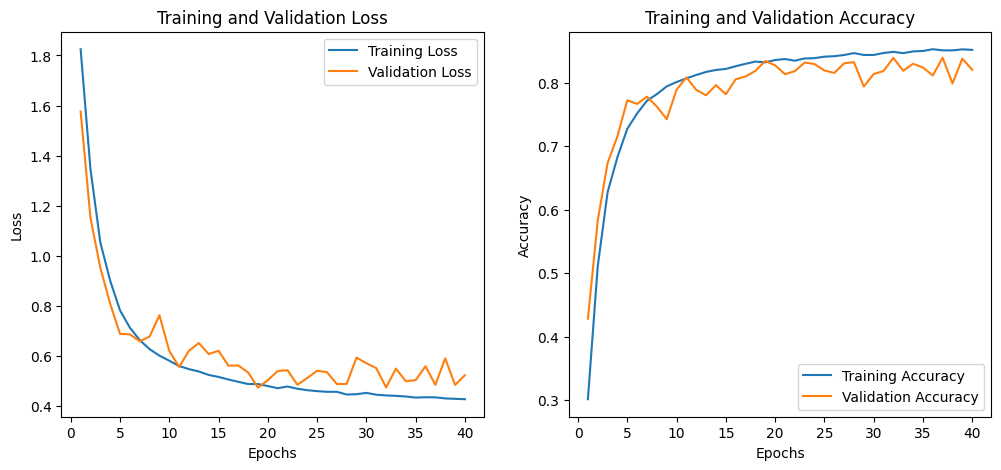

In [41]:
plot_training_results(train_costs, val_costs, train_accuracies, val_accuracies)


# Resnet44 model Implementation

In [42]:

optimizer_44 = optim.SGD(resnet44_model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)


In [43]:
train_costs, val_costs, train_accuracies,val_accuracies,best_model_state = train_model(resnet44_model, train_loader, val_loader, criterion, optimizer_44, num_epochs=35)


Validation: 100%|██████████| 157/157 [00:03<00:00, 43.31it/s]


[Epoch 1/35]: train-loss = 1.865801 | train-acc = 0.292 | val-loss = 1.813734 | val-acc = 0.372


Validation: 100%|██████████| 157/157 [00:04<00:00, 37.56it/s]


[Epoch 2/35]: train-loss = 1.455950 | train-acc = 0.465 | val-loss = 1.302861 | val-acc = 0.550


Validation: 100%|██████████| 157/157 [00:03<00:00, 50.87it/s]


[Epoch 3/35]: train-loss = 1.076249 | train-acc = 0.617 | val-loss = 1.226022 | val-acc = 0.579


Validation: 100%|██████████| 157/157 [00:03<00:00, 49.21it/s]


[Epoch 4/35]: train-loss = 0.875569 | train-acc = 0.694 | val-loss = 0.876402 | val-acc = 0.699


Validation: 100%|██████████| 157/157 [00:03<00:00, 47.60it/s]


[Epoch 5/35]: train-loss = 0.761256 | train-acc = 0.738 | val-loss = 0.712456 | val-acc = 0.757


Validation: 100%|██████████| 157/157 [00:04<00:00, 37.23it/s]


[Epoch 6/35]: train-loss = 0.687803 | train-acc = 0.762 | val-loss = 0.729954 | val-acc = 0.748


Validation: 100%|██████████| 157/157 [00:03<00:00, 50.39it/s]


[Epoch 7/35]: train-loss = 0.642035 | train-acc = 0.778 | val-loss = 0.628830 | val-acc = 0.782


Validation: 100%|██████████| 157/157 [00:03<00:00, 50.07it/s]


[Epoch 8/35]: train-loss = 0.606365 | train-acc = 0.794 | val-loss = 0.602937 | val-acc = 0.793


Validation: 100%|██████████| 157/157 [00:03<00:00, 52.29it/s]


[Epoch 9/35]: train-loss = 0.579326 | train-acc = 0.801 | val-loss = 0.565160 | val-acc = 0.803


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.26it/s]


[Epoch 10/35]: train-loss = 0.559844 | train-acc = 0.808 | val-loss = 0.573783 | val-acc = 0.805


Validation: 100%|██████████| 157/157 [00:03<00:00, 51.01it/s]


[Epoch 11/35]: train-loss = 0.538746 | train-acc = 0.815 | val-loss = 0.565047 | val-acc = 0.805


Validation: 100%|██████████| 157/157 [00:03<00:00, 51.33it/s]


[Epoch 12/35]: train-loss = 0.523658 | train-acc = 0.819 | val-loss = 0.704675 | val-acc = 0.767


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.03it/s]


[Epoch 13/35]: train-loss = 0.512231 | train-acc = 0.824 | val-loss = 0.663196 | val-acc = 0.777


Validation: 100%|██████████| 157/157 [00:03<00:00, 47.51it/s]


[Epoch 14/35]: train-loss = 0.497830 | train-acc = 0.829 | val-loss = 0.526596 | val-acc = 0.820


Validation: 100%|██████████| 157/157 [00:03<00:00, 51.27it/s]


[Epoch 15/35]: train-loss = 0.489710 | train-acc = 0.832 | val-loss = 0.531762 | val-acc = 0.817


Validation: 100%|██████████| 157/157 [00:03<00:00, 50.27it/s]


[Epoch 16/35]: train-loss = 0.483578 | train-acc = 0.834 | val-loss = 0.624029 | val-acc = 0.789


Validation: 100%|██████████| 157/157 [00:03<00:00, 41.44it/s]


[Epoch 17/35]: train-loss = 0.473146 | train-acc = 0.839 | val-loss = 0.551469 | val-acc = 0.813


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.83it/s]


[Epoch 18/35]: train-loss = 0.465696 | train-acc = 0.840 | val-loss = 0.468757 | val-acc = 0.842


Validation: 100%|██████████| 157/157 [00:03<00:00, 47.97it/s]


[Epoch 19/35]: train-loss = 0.461623 | train-acc = 0.842 | val-loss = 0.474303 | val-acc = 0.836


Validation: 100%|██████████| 157/157 [00:03<00:00, 48.46it/s]


[Epoch 20/35]: train-loss = 0.455808 | train-acc = 0.843 | val-loss = 0.468770 | val-acc = 0.842


Validation: 100%|██████████| 157/157 [00:03<00:00, 40.54it/s]


[Epoch 21/35]: train-loss = 0.446761 | train-acc = 0.846 | val-loss = 0.489063 | val-acc = 0.835


Validation: 100%|██████████| 157/157 [00:03<00:00, 48.68it/s]


[Epoch 22/35]: train-loss = 0.447796 | train-acc = 0.847 | val-loss = 0.443831 | val-acc = 0.844


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.48it/s]


[Epoch 23/35]: train-loss = 0.436050 | train-acc = 0.851 | val-loss = 0.526289 | val-acc = 0.820


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.32it/s]


[Epoch 24/35]: train-loss = 0.437886 | train-acc = 0.849 | val-loss = 0.475490 | val-acc = 0.834


Validation: 100%|██████████| 157/157 [00:03<00:00, 50.56it/s]


[Epoch 25/35]: train-loss = 0.434297 | train-acc = 0.851 | val-loss = 0.551546 | val-acc = 0.815


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.33it/s]


[Epoch 26/35]: train-loss = 0.427902 | train-acc = 0.853 | val-loss = 0.487887 | val-acc = 0.835


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.23it/s]


[Epoch 27/35]: train-loss = 0.424657 | train-acc = 0.856 | val-loss = 0.467889 | val-acc = 0.843


Validation: 100%|██████████| 157/157 [00:03<00:00, 50.08it/s]


[Epoch 28/35]: train-loss = 0.424574 | train-acc = 0.855 | val-loss = 0.618076 | val-acc = 0.798


Validation: 100%|██████████| 157/157 [00:03<00:00, 50.37it/s]


[Epoch 29/35]: train-loss = 0.417407 | train-acc = 0.857 | val-loss = 0.526770 | val-acc = 0.824


Validation: 100%|██████████| 157/157 [00:03<00:00, 39.86it/s]


[Epoch 30/35]: train-loss = 0.411019 | train-acc = 0.860 | val-loss = 0.557382 | val-acc = 0.813


Validation: 100%|██████████| 157/157 [00:03<00:00, 49.09it/s]


[Epoch 31/35]: train-loss = 0.416367 | train-acc = 0.858 | val-loss = 0.508027 | val-acc = 0.838


Validation: 100%|██████████| 157/157 [00:03<00:00, 50.12it/s]


[Epoch 32/35]: train-loss = 0.412523 | train-acc = 0.860 | val-loss = 0.461245 | val-acc = 0.839


Validation: 100%|██████████| 157/157 [00:03<00:00, 42.28it/s]


[Epoch 33/35]: train-loss = 0.410087 | train-acc = 0.860 | val-loss = 0.514385 | val-acc = 0.826


Validation: 100%|██████████| 157/157 [00:03<00:00, 46.27it/s]


[Epoch 34/35]: train-loss = 0.408693 | train-acc = 0.861 | val-loss = 0.452105 | val-acc = 0.843


Validation: 100%|██████████| 157/157 [00:03<00:00, 50.14it/s]

[Epoch 35/35]: train-loss = 0.397279 | train-acc = 0.864 | val-loss = 0.489666 | val-acc = 0.836


In [44]:
# Save the trained model
model_save_path = "/content/drive/MyDrive/SEM3/Interview_Asignment/resnet_44.pth"
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

torch.save(best_model_state, model_save_path)

In [45]:
model= ResNet44(10)
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [46]:

correct = 0

model.eval().cuda()

with  torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Make predictions.
        prediction = model(inputs)

        # Retrieve predictions indexes.
        _, predicted_class = torch.max(prediction.data, 1)

        # Compute number of correct predictions.
        correct += (predicted_class == labels).float().sum().item()

test_accuracy = correct / test_samples
print('Test accuracy: {}'.format(test_accuracy))

Test accuracy: 0.8329


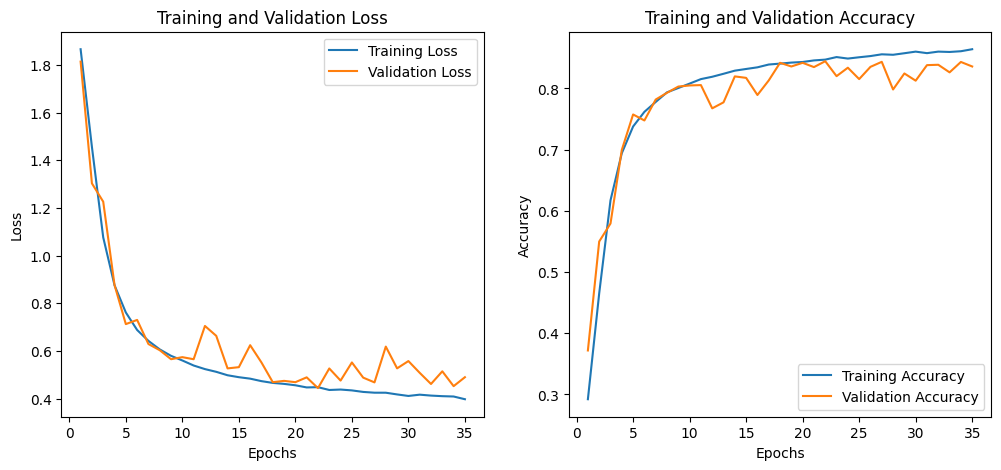

In [47]:
plot_training_results(train_costs, val_costs, train_accuracies, val_accuracies)


# References ->
https://arxiv.org/abs/1512.03385
